In [1]:
## this deactivates the gpu, if other processes are already running on it
## otherwise don't execute this cell
from tensorflow.config import set_visible_devices, get_visible_devices

try:
    # Disable all GPUS
    print("test")
    set_visible_devices([], 'GPU')
    print("okay")
    visible_devices = get_visible_devices()
    print("here")
    for device in visible_devices:
        #print("assert failed")
        assert device.device_type != 'GPU'
        print("assert worked")
except:
    # Invalid device or cannot modify virtual devices once initialized.
    print("nope")
    pass

test
okay
here
assert worked


# Augmented Liver Section Segmentation
Data: liver section and annotations of fat blobs<br />
Goal: semantic segmentation of fat blobs<br />
Idea: *U-Net* CNN

<img src="Images/u-net-architecture.png" width=700 />

## Setup

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, TensorBoard
from tensorflow.keras.backend import clear_session
import segmentation_models as sm
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from packaging import version
import os

from IPython.display import clear_output

Segmentation Models: using `tf.keras` framework.


## Set Backbone and Define Preprocessor
Training CNNs from scratch is difficult $\rightarrow$ *transfer learning*

Alternatively use manual U-Net with custom preprocessing function. This scales the image data to $[-1,+1]$, so it may need adjustment if, e.g., other types of activations are used.

In [2]:
## uncomment for segmentation_model U-Net
#BACKBONE = 'inceptionresnetv2' #'mobilenetv2'
#preprocess_input = sm.get_preprocessing(BACKBONE)

## alternative for manual U-Net
def custom_preprocess(imgs):
    return np.interp(imgs, (imgs.min(), imgs.max()), (0,1))#(-1, +1))

preprocess_input = custom_preprocess

## Create Generators
`ImageDataGenerator` applies data augmentation online. The iterator created from it can iterate over images from a directory, transform them, and provide them to the learning algorithm in mini-batches. It's important to activate the same transformations for both, so that the seeding mechanism works and both images and masks are transformed in the same way.

In [5]:
image_datagen = ImageDataGenerator(
#    featurewise_center=False,
#    samplewise_center=True,
#    featurewise_std_normalization=True,
#    samplewise_std_normalization=True,
#    zca_whitening=True,
#    zca_epsilon=1e-06,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
#    brightness_range=[0.7, 1.3],
    shear_range=10.0,
    zoom_range=[0.2, 0.3],
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.2)
mask_datagen = ImageDataGenerator(
#    featurewise_center=False,
#    samplewise_center=True,
#    featurewise_std_normalization=True,
#    samplewise_std_normalization=True,
#    zca_whitening=True,
#    zca_epsilon=1e-06,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
#    brightness_range=[0.7, 1.3],
    shear_range=10.0,
    zoom_range=[0.2,0.3],
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.2)


# fixed RNG seed to make sure images and masks are transformed in the same way
seed = 299

batch_size = 128

# initialize the iterators from the generators above
# they will iterate over all the images in the given directories
# class_mode=None makes sure that no class labels are returned, since 
# the masks are the labels themselves
image_iterator = image_datagen.flow_from_directory("Imgs", 
                                                   class_mode=None,
                                                   batch_size=batch_size, 
                                                   seed=seed,
                                                   subset="training")
mask_iterator   = mask_datagen.flow_from_directory("Masks",
                                                   class_mode=None,
                                                   batch_size=batch_size, 
                                                   seed=seed,
                                                   subset="training")

val_image_iterator = image_datagen.flow_from_directory("Imgs", 
                                                   class_mode=None,
                                                   batch_size=batch_size, 
                                                   seed=seed,
                                                   subset="validation")
val_mask_iterator   = mask_datagen.flow_from_directory("Masks",
                                                   class_mode=None,
                                                   batch_size=batch_size, 
                                                   seed=seed,
                                                   subset="validation")

train_iterator = zip(image_iterator, mask_iterator)
val_iterator = zip(val_image_iterator, val_mask_iterator)  ## will show 0 images found, but we don't need it now

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


## Iterator for later testing without augmentations

In [6]:
test_image_datagen = ImageDataGenerator(zoom_range=[0.2,0.3], preprocessing_function=preprocess_input)
test_mask_datagen = ImageDataGenerator(zoom_range=[0.2,0.3], preprocessing_function=preprocess_input)


# fixed RNG seed to make sure images and masks are transformed in the same way
seed = 42

# initialize the iterators from the generators above
# they will iterate over all the images in the given directories
# class_mode=None makes sure that no class labels are returned, since 
# the masks are the labels themselves
test_image_iterator = test_image_datagen.flow_from_directory("Imgs", 
                                                   class_mode=None,
                                                   batch_size=8, 
                                                   seed=seed)
test_mask_iterator  = test_mask_datagen.flow_from_directory("Masks",
                                                   class_mode=None,
                                                   batch_size=8, 
                                                   seed=seed)

test_iterator = zip(test_image_iterator, test_mask_iterator)

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


## Online Data Augmentation
* CNN considers rotated, translated etc. images as different
* Invariance can be enforced architecturally, or by representation in data
* Here: learn invariance from data $\rightarrow$ *data augmentation*
* Make sure they are all sensible:


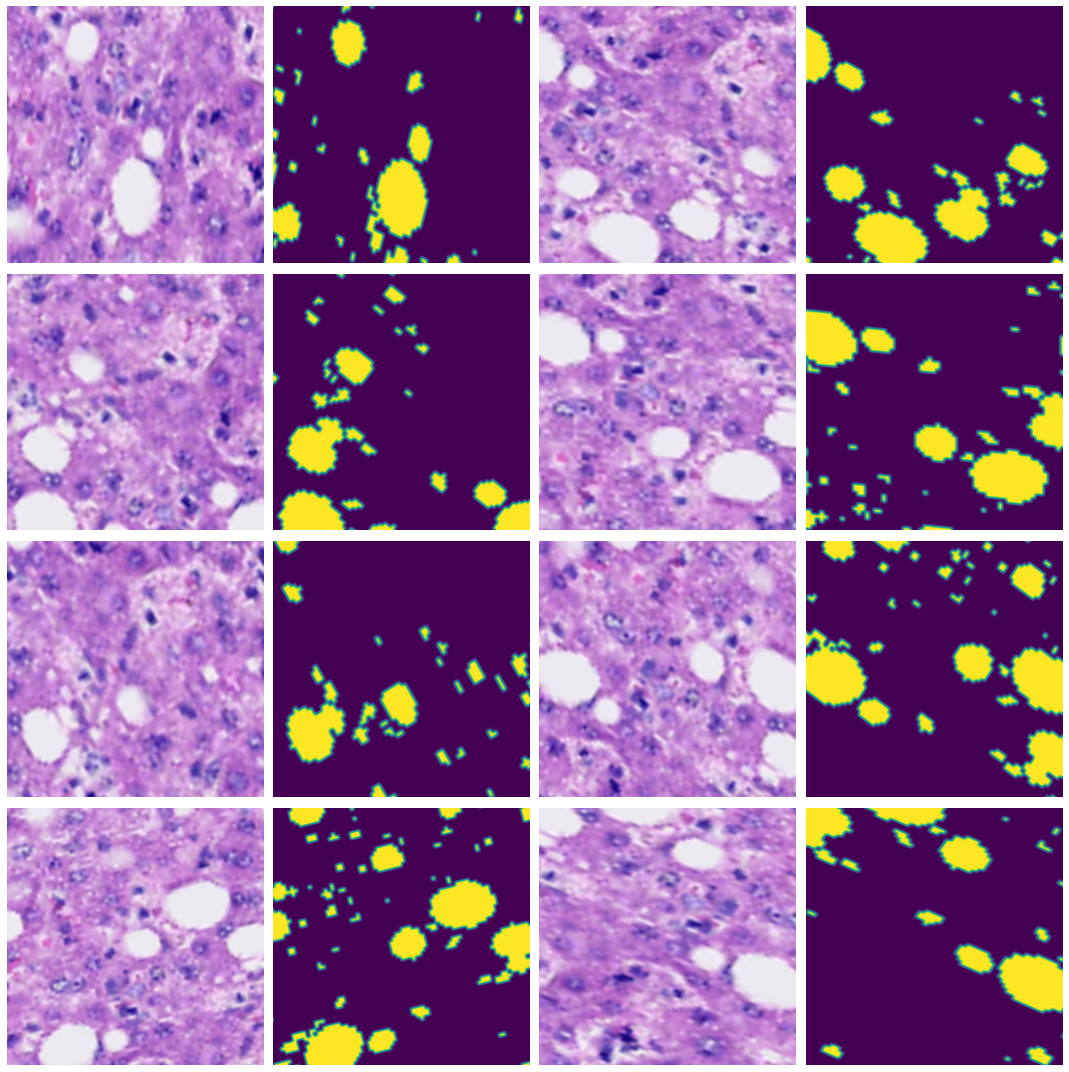

In [7]:
fig,axs = plt.subplots(4,4, figsize=(15,15))
axs = axs.flatten()

img, mask = next(train_iterator)

#for i in range(8):
#    axs[2*i].imshow((img[i]+1)/2)
#    axs[2*i+1].imshow((mask[i]+1)/2)
    
#for i in range(8):
#    img, mask = next(train_iterator)
#    axs[2*i].imshow((img[0]+1)/2)
#    axs[2*i+1].imshow((mask[0]+1)/2)
    
for i in range(8):
    img, mask = next(train_iterator)
    axs[2*i].imshow(img[0])
    axs[2*i+1].imshow(mask[0,:,:,0])
    
#for i in range(8):
#    axs[2*i].imshow(img[i]/255)
#    axs[2*i+1].imshow(mask[i]/255)
    
    
for ax in axs:
    ax.axis("off")

plt.tight_layout()

In [8]:
print(img.shape)
print(mask.shape)

(1, 256, 256, 3)
(1, 256, 256, 3)


## Alternative: Manual U-Net

In [24]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Conv2D, SeparableConv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, add
from tensorflow.keras import Model, Input

clear_session()
                        

def get_model(img_size, num_classes, filter_sizes, activation, batch_norm=True):
    # the input layer determines the image size input into the network
    inputs = Input(shape=img_size + (3,))   # 3 means RGB

    ### downsampling

    # entry block
    x = Conv2D(filter_sizes[0], 3, strides=2, padding="same")(inputs)
    if batch_norm: x = BatchNormalization()(x)
    x = Activation(activation)(x)

    previous_block_activation = x  # Set aside residual

    # next blocks are identical apart from the feature depth
    for filters in filter_sizes[1:]: 
        x = Activation(activation)(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        if batch_norm: x = BatchNormalization()(x)

        x = Activation(activation)(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        if batch_norm: x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### upscaling

    for filters in filter_sizes[::-1]:
        x = Activation(activation)(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        if batch_norm: x = BatchNormalization()(x)

        x = Activation(activation)(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        if batch_norm: x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        # Project residual
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding="same")(residual)
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # per-pixel classification layer
    outputs = Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x) # softmax

    # create the model
    model = Model(inputs, outputs)
    
    return model


# Build model
model = get_model((256,256), 1, [32, 64, 128, 256, 512], "selu", True)

# and compile it
model.compile('adam', loss=sm.losses.binary_focal_dice_loss, metrics=[sm.metrics.iou_score])

## Train Model with TensorBoard and Custom Callback for Online Info

In [25]:
#!rm -rf ./logs
#logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#
#tboard_callback = TensorBoard(log_dir = logs,
#                              histogram_freq = 1,
#                              profile_batch = '500,520')

class CustomCallback(Callback):
    def __init__(self, epochs):
        self.epochs = epochs
        
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.metric = []
        self.val_metric = []
        
        self.samples = 4
        
        img, mask = next(test_iterator)
        
        self.img, self.mask = np.zeros((self.samples, *img.shape[1:])), np.zeros((self.samples, *mask.shape[1:]))
        for i in range(self.samples):
            img, mask = next(test_iterator)
            self.img[i], self.mask[i] = img.reshape(-1,*img.shape), mask.reshape(-1,*mask.shape)
            
        #while self.img.shape[0] < self.samples:
        #    self.img, self.mask = next(test_iterator)
        
        #self.samples = min(self.img.shape[0], 6)
        #print(self.samples)
            

    def on_epoch_end(self, epoch, logs={}):
        self.x.append(epoch)
        self.losses.append(logs["loss"])
        self.val_losses.append(logs["val_loss"])
        self.metric.append(logs["iou_score"])
        self.val_metric.append(logs["val_iou_score"])
        
        epoch_pred = model.predict(self.img.reshape(self.img.shape[0],256,256,3))
        
        clear_output(wait=True)
        
        fig = plt.figure(figsize=(16,16))
        axs = []
        axs.append(fig.add_subplot(2+self.samples,2,1))
        axs.append(fig.add_subplot(2+self.samples,2,2))
        for i in range(self.samples): #self.samples):
            for j in range(6):
                #print(i,j,(2+self.samples)*i+j+2+self.samples+1)
                axs.append(fig.add_subplot(2+self.samples,6,(2+self.samples)*i+j+2+self.samples+1))
    
        fig.suptitle(f"Epoch {epoch}", fontsize=24)
        
        axs[0].plot(self.x, self.losses, lw=4, label="loss")
        axs[0].plot(self.x, self.val_losses, lw=4, label="val_loss")
        axs[0].legend(fontsize=16)
        axs[0].set_xlabel("Epoch", fontsize=16)
        axs[0].set_ylabel("Loss", fontsize=16)
        axs[0].set_yscale("log")
        
        axs[1].plot(self.x, self.losses, lw=4, label="iou_score")
        axs[1].plot(self.x, self.val_losses, lw=4, label="val_iou_score")
        axs[1].legend(fontsize=16)
        axs[1].set_xlabel("Epoch", fontsize=16)
        axs[1].set_ylabel("Metric", fontsize=16)
        #axs[1].set_yscale("log")
        
        [axs[k].set_xlim([0,self.epochs-1]) for k in range(2)]
        
        
        # uncomment following when noisy data is used
        titles = ["Image", "Prediction", "Ground Truth", "Pred Overlay", "GT Overlay", "Difference"]

        y_pred_thresh = epoch_pred.copy()
        y_pred_thresh = np.interp(y_pred_thresh, (y_pred_thresh.min(), y_pred_thresh.max()), (0, +1))
        #y_pred_thresh[y_pred_thresh<thresh] = np.nan
        
        #axs[1].hist(y_pred_thresh.flatten(), bins=20, density=True)
        
        x_test_ranged = self.img.copy()
        x_test_ranged = np.interp(x_test_ranged, (x_test_ranged.min(), x_test_ranged.max()), (0, +1)) #(x_test_ranged+1)/2
        
        y_test_ranged = self.mask.copy()
        y_test_ranged = np.interp(y_test_ranged, (y_test_ranged.min(), y_test_ranged.max()), (0, +1)) #(y_test_ranged+1)/2
        #y_test_ranged[y_test_ranged<0.6] = np.nan
            
        #fig,axs = plt.subplots(samples,6, figsize=(16,3*samples))
        
        diff_vals = y_test_ranged[:,:,:,0]-y_pred_thresh[:,:,:,0] #((y_test_ranged-y_pred_thresh)+1)/2
        diff_vals = np.interp(diff_vals, (diff_vals.min(), diff_vals.max()), (0, +1))
        
        for i in range(self.samples):
            axs[2+6*i+0].imshow(x_test_ranged[i])
            axs[2+6*i+1].imshow(y_pred_thresh[i])
            axs[2+6*i+2].imshow(y_test_ranged[i,:,:,0])
            axs[2+6*i+3].imshow(x_test_ranged[i])
            axs[2+6*i+3].imshow(y_pred_thresh[i], alpha=0.5)
            axs[2+6*i+4].imshow(x_test_ranged[i])
            axs[2+6*i+4].imshow(y_test_ranged[i,:,:,0], alpha=0.5)
            axs[2+6*i+5].imshow(diff_vals[i], cmap='Spectral')
            for j in range(6):
                axs[2+6*i+j].axis("off")
                
        for i in range(6):
            axs[2+i].set_title(titles[i], fontsize=15)
        #axs[0,1].set_title("Prediction", fontsize=26)
        #axs[0,2].set_title("Ground Truth", fontsize=26)
        #axs[0,3].set_title("Overlay", fontsize=26)
        plt.tight_layout()
        
        plt.savefig(f"Anim/training_anim_{epoch}.png")
        plt.show()
        
        # place your conditional statement here
        # it should check whether the current loss is below 3.3*10^-3 and then
        # set self.model.stop_training to True
        # you can additionally provide a print() statement
        ### BEGIN SOLUTION
        #if logs["loss"][-1] < 3.3e-3:
        #    print(f"Loss < 3.3e-3, stopping training early at epoch {epoch}")
        #    self.model.stop_training = True
        ### END SOLUTION
        

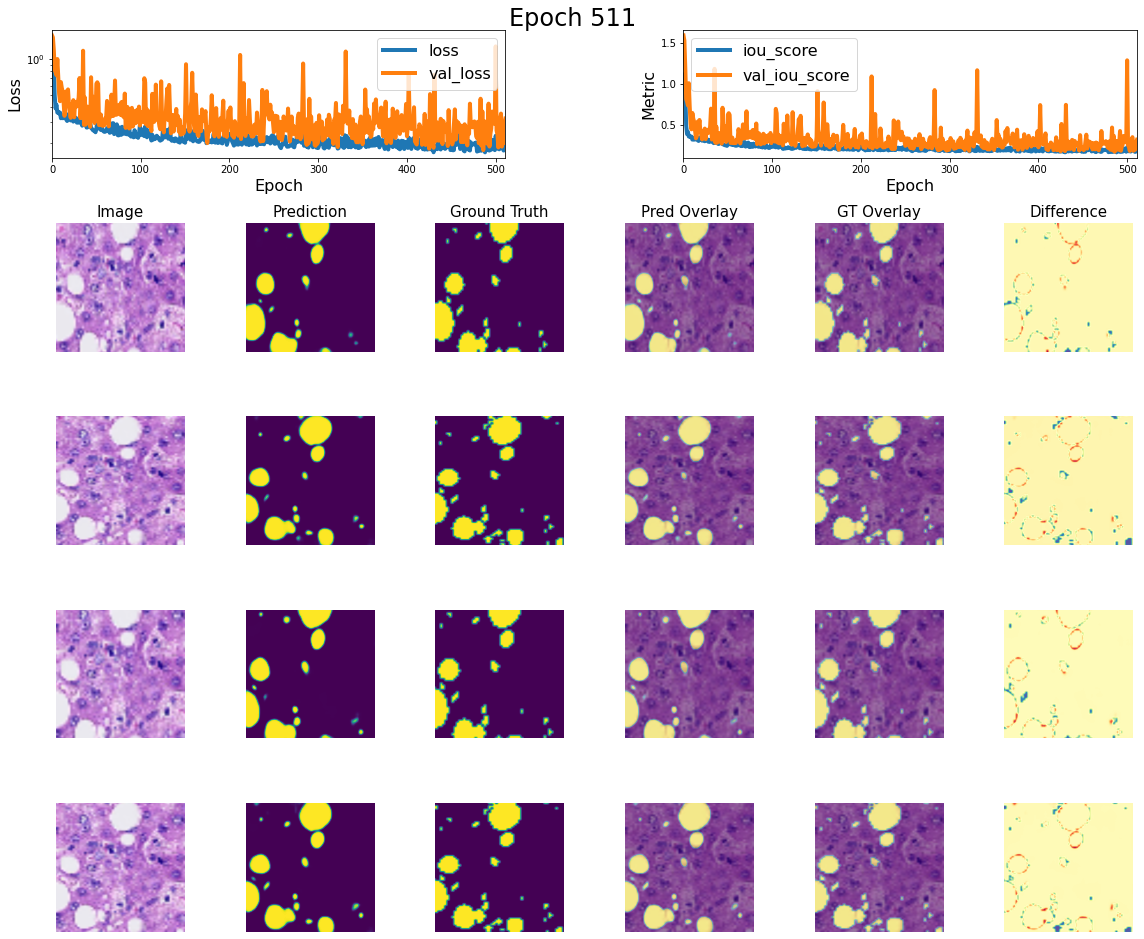

In [26]:
epochs = 512
custom_callback = CustomCallback(epochs)

history = model.fit(train_iterator, 
                    validation_data=train_iterator, #val_iterator, 
                    validation_steps=16,
                    batch_size=batch_size, 
                    steps_per_epoch=64, #64
                    epochs=epochs,
                    #callbacks = [tboard_callback, plot_losses],
                    callbacks=custom_callback,
                    verbose=1)

#plt.savefig("loss_plots_n.pdf")

### Create animation from callback images

In [27]:
from IPython.display import Video

!rm training_anim.mp4
!ffmpeg -r 8 -s 1152x1152 -i Anim/training_anim_%01d.png -vcodec libx264 -crf 15 -pix_fmt yuv420p training_anim.mp4 -hide_banner -loglevel error

Video("training_anim.mp4")#, embed=True)

### Opens a tensorboard server, not necessary

In [8]:
%load_ext tensorboard

%tensorboard --logdir logs --host 127.0.0.1 #isd-hawking.isd.uni-stuttgart.de

In [10]:
!pkill tensorboard

## Training History

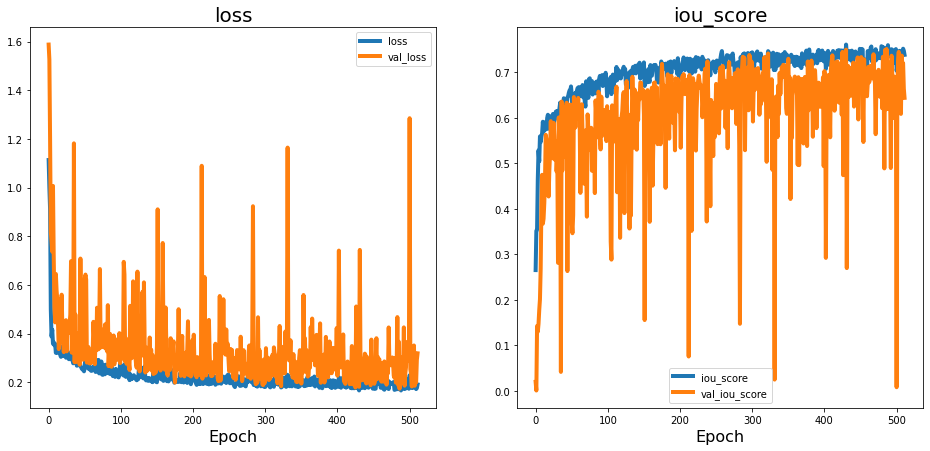

In [28]:
fig,axs = plt.subplots(1,2, figsize=(16,7))

for i,key in enumerate(model.history.history.keys()):
    axs[i%2].set_title(key[4:], fontsize=20)
    axs[i%2].plot(model.history.history[key], lw=4, label=key)
    axs[i%2].set_xlabel("Epoch", fontsize=16)
    axs[i%2].legend()
 

## Save and Load Model

In [127]:
model.save("model_name")

INFO:tensorflow:Assets written to: flow_model_focal_dice_tanh_bigger2/assets


In [145]:
from tensorflow.keras.models import load_model

model = load_model("model_name", 
                   custom_objects={"binary_focal_loss_plus_dice_loss": sm.losses.binary_focal_dice_loss, 
                                   "iou_score": sm.metrics.iou_score})

## Generate new images for testing

In [29]:
samples = 8

test_img, test_mask = np.zeros((8, *img.shape[1:])), np.zeros((8, *mask.shape[1:]))
y_hat_mask = np.zeros((8, 256, 256, 1))

for i in range(8):
    img, mask = next(test_iterator)
    test_img[i], test_mask[i] = img.reshape(-1,*img.shape), mask.reshape(-1, *mask.shape)
    y_hat_mask[i] = model.predict(img)#.reshape(img.shape[0],256,256,3))
    
y_hat_mask.shape
test_mask.shape

(8, 256, 256, 3)

## Evaluate IoU-score on Test Batch

In [30]:
model.evaluate(test_iterator, steps=32)#, workers=16, use_multiprocessing=True, verbose=1)

32/32 [==============================] - 2s 76ms/step - loss: 0.1538 - iou_score: 0.7801


[0.1537749320268631, 0.7801488637924194]

## Plot Predictions and Compare

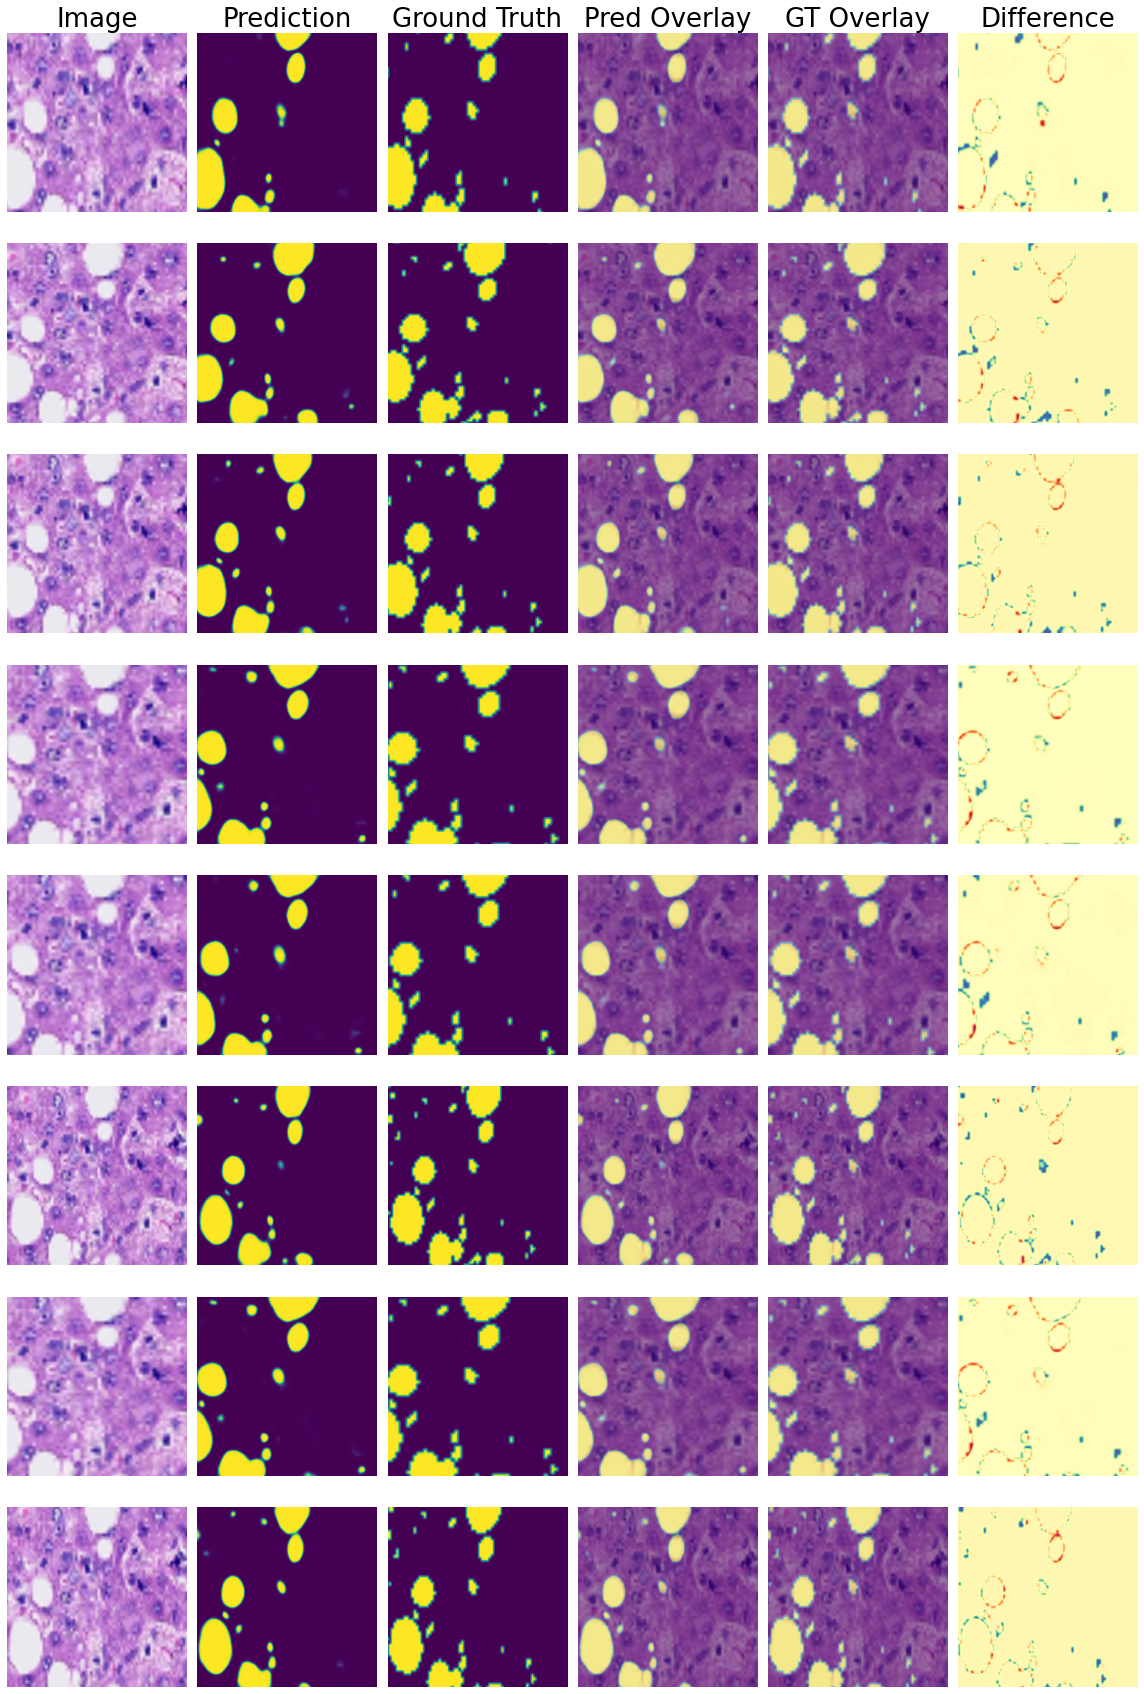

In [31]:
samples = 8 # max batch_size
thresh = 0.9

titles = ["Image", "Prediction", "Ground Truth", "Pred Overlay", "GT Overlay", "Difference"]

y_pred_thresh = y_hat_mask.copy()
#y_pred_thresh[y_pred_thresh<thresh] = np.nan

x_test_ranged = test_img.copy()
#x_test_ranged = (x_test_ranged+1)/2

y_test_ranged = test_mask.copy()
#y_test_ranged = (y_test_ranged+1)/2
#y_test_ranged[y_test_ranged<0.6] = np.nan

diff_vals = y_test_ranged[:,:,:,0]-y_pred_thresh[:,:,:,0] #((y_test_ranged-y_pred_thresh)+1)/2
diff_vals = np.interp(diff_vals, (diff_vals.min(), diff_vals.max()), (0, +1))

fig,axs = plt.subplots(samples,6, figsize=(16,3*samples))


for i in range(samples):
    axs[i,0].imshow(x_test_ranged[i])
    axs[i,1].imshow(y_pred_thresh[i])
    axs[i,2].imshow(y_test_ranged[i,:,:,0])
    axs[i,3].imshow(x_test_ranged[i])
    axs[i,3].imshow(y_pred_thresh[i], alpha=0.5)
    axs[i,4].imshow(x_test_ranged[i])
    axs[i,4].imshow(y_test_ranged[i,:,:,0], alpha=0.5)
    axs[i,5].imshow(diff_vals[i], cmap="Spectral")
    #axs[i,5].imshow(y_pred_thresh[i], alpha=0.5)
    for j in range(6):
        axs[i,j].axis("off")
        
for j in range(6):
    axs[0,j].set_title(titles[j], fontsize=26)
#axs[0,1].set_title("Prediction", fontsize=26)
#axs[0,2].set_title("Ground Truth", fontsize=26)
#axs[0,3].set_title("Overlay", fontsize=26)
plt.tight_layout()

plt.savefig("segmentation_probs.png")

## Segment Whole Image

In [32]:
#del full_image_datagen
#del full_mask_datagen
#del full_image_iterator
#del full_mask_iterator
#del full_iterator

full_image_datagen = ImageDataGenerator()
full_mask_datagen = ImageDataGenerator()


# fixed RNG seed to make sure images and masks are transformed in the same way
seed = 42

batch_size = 32

full_image_iterator = full_image_datagen.flow_from_directory("Imgs", 
                                                   class_mode=None, 
                                                   seed=seed)
full_mask_iterator   = full_mask_datagen.flow_from_directory("Masks",
                                                   class_mode=None,
                                                   seed=seed)



full_iterator = zip(full_image_iterator, full_mask_iterator)


Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


IndexError: index 1 is out of bounds for axis 0 with size 1

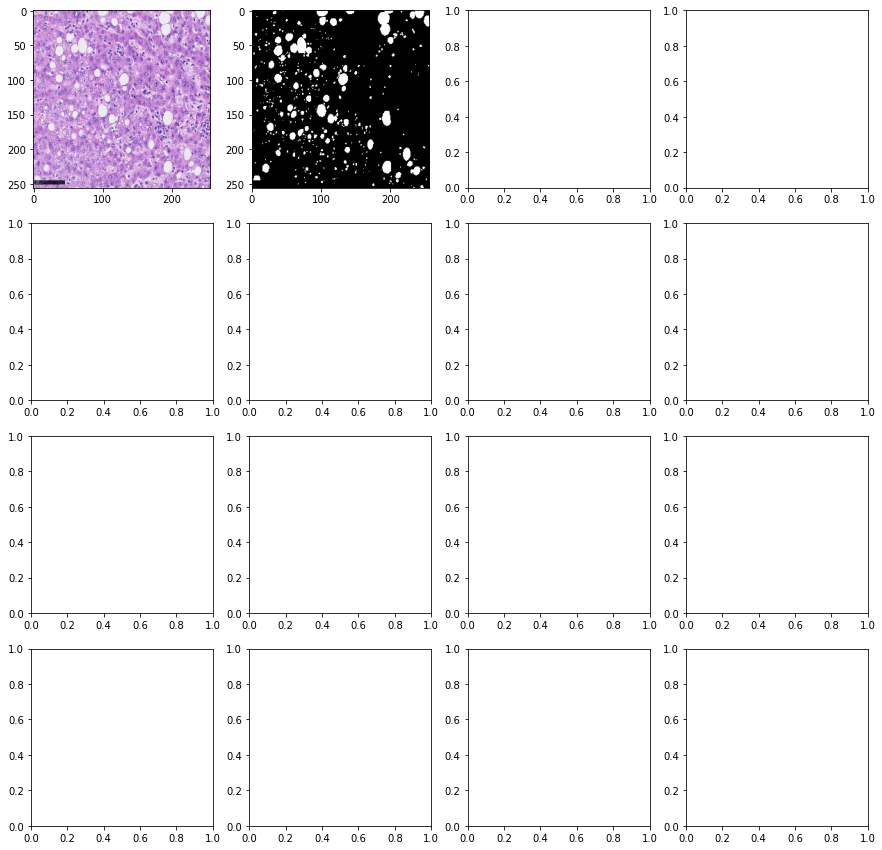

In [33]:
fig,axs = plt.subplots(4,4, figsize=(15,15))
axs = axs.flatten()

full_img, full_mask = next(full_iterator)
full_img = preprocess_input(full_img)
full_mask = preprocess_input(full_mask)


for i in range(8):
    axs[2*i].imshow(full_img[i])
    axs[2*i+1].imshow(full_mask[i])
    
for ax in axs:
    ax.axis("off")

plt.tight_layout()

In [34]:
plt.figure()

full_img[0].shape

#plt.imshow(timg)

### WHYYYY?

(256, 256, 3)

<Figure size 432x288 with 0 Axes>

In [35]:
y_full_pred = model.predict(full_img)

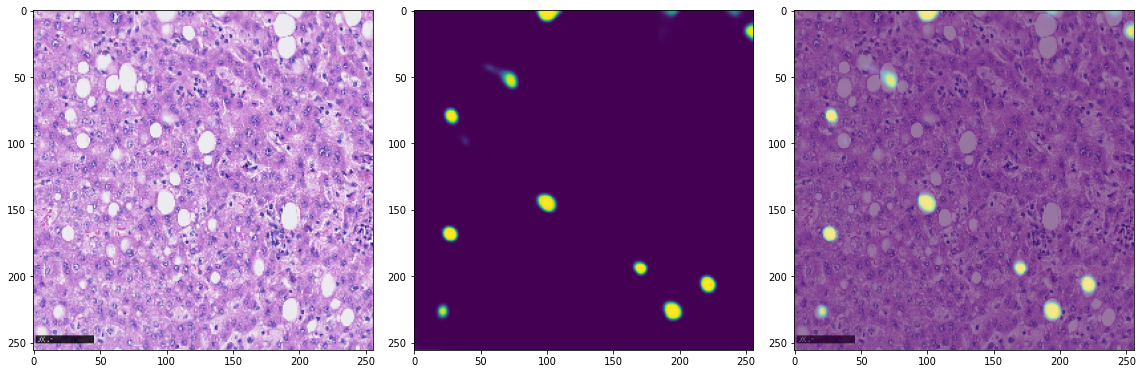

In [36]:
fig,axs = plt.subplots(1,3, figsize=(16,7))

sample = 0

axs[0].imshow(full_img[sample])
axs[1].imshow(y_full_pred[sample])
axs[2].imshow(full_img[sample])
axs[2].imshow(y_full_pred[sample], alpha=0.5)

#for ax in axs:
#    ax.axis("off")
plt.tight_layout()

### Load Full Image Manually

In [37]:
from PIL import Image
from skimage.transform import resize

### helper function for full predictions
def predict_full(sample, slice_size, threshold=0.1, savefig=False):
    t_image = preprocess_input(np.asarray(Image.open(f'Imgs/img/J-19-0153-{sample}_HE.jpg')))
    t_mask  = preprocess_input(np.asarray(Image.open(f'Masks/img/J-19-0153-{sample}_mask_HE.png')))#.convert('L')))
    
    x_step = t_image.shape[0]//slice_size
    y_step = t_image.shape[1]//slice_size

    full_slices = []
    
    for i in range(x_step):
        for j in range(y_step):
            full_slices.append(t_image[i*slice_size:(i+1)*slice_size,j*slice_size:(j+1)*slice_size])
            
    full_slices = np.array(full_slices)
    
    full_slices_resized = resize(full_slices, (full_slices.shape[0],256,256,3))
    
    slice_preds = model.predict(full_slices_resized)
    
    slice_preds_resized = resize(slice_preds, (slice_preds.shape[0],slice_size,slice_size,3))
    
    full_pred = np.zeros((x_step*slice_size, y_step*slice_size))
    
    k = 0
    
    for i in range(x_step):
        for j in range(y_step):
            full_pred[i*slice_size:(i+1)*slice_size,j*slice_size:(j+1)*slice_size] = slice_preds_resized[k,:,:,0]
            k += 1
            
    titles = ["Image", "Prediction", "Ground Truth", "Image + Pred", "Image + GT", "GT - Pred"]
    
    fig,axs = plt.subplots(2,3, figsize=(16,9))
    
    t_image_rescaled = (t_image+1)/2
    full_pred_thresh = full_pred.copy()
    full_pred_thresh = (full_pred_thresh+1)/2
    full_pred_thresh[full_pred_thresh<threshold] = 0.0
    
    
    t_mask_resized = (t_mask[:x_step*slice_size,:y_step*slice_size]+1)/2
    
    axs[0,0].imshow(t_image_rescaled)
    axs[0,1].imshow(full_pred_thresh)
    axs[0,2].imshow(t_mask_resized)
    
    axs[1,0].imshow(t_image_rescaled)
    axs[1,0].imshow(full_pred_thresh, alpha=0.5)
    axs[1,1].imshow(t_image_rescaled)
    axs[1,1].imshow(t_mask_resized, alpha=0.3)
    #axs[1,2].imshow((t_mask+1)/2)
    #axs[1,2].imshow((full_pred_thresh+1)/2, alpha=0.5)
    axs[1,2].imshow(t_mask_resized - full_pred_thresh, cmap="Spectral")
    
    axs = axs.flatten()
    for i,ax in enumerate(axs):
        ax.set_title(titles[i], fontsize=20)
        ax.axis("off")
        
    plt.tight_layout()
    
    if savefig:
        plt.savefig(f"full_prediction_{sample}_{slice_size}x{slice_size}_{threshold}.png")

## Predict for all images in the folder
Sometimes -1 and +1 are switched, so the following interpretation may be reversed. In the difference plot, red areas were predicted where there is no fat marked in the mask, blue areas are missing predictions for pixels marked in the mask that the network failed to find.

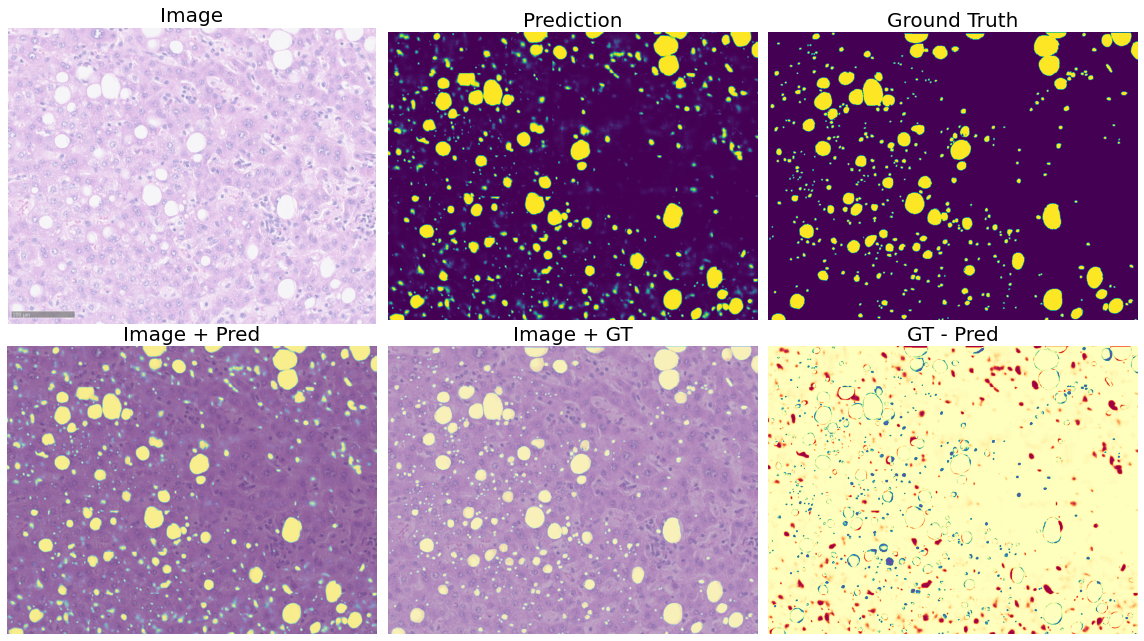

In [42]:
for num in ["10"]:#["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]:
    # filename modifier, crop size, threshold that counts as detection, save all figures in files
    predict_full(num, 140, 0.1, False)

---